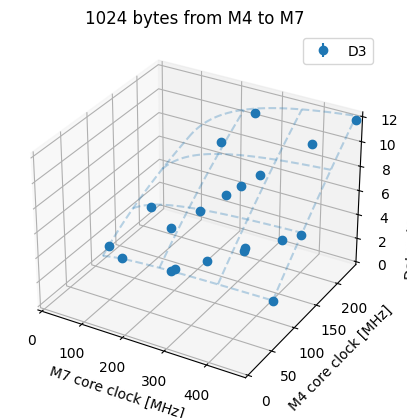

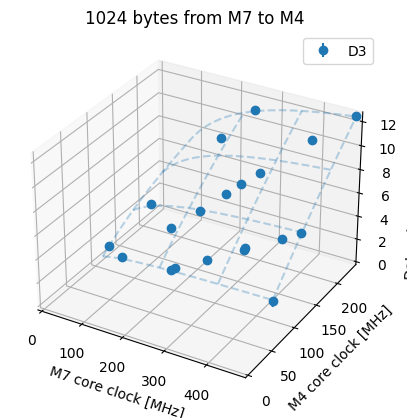

In [4]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import measurement
import visu_3d
import linear_model
import visu_common

mems = visu_common.get_mems('.', r'D3')
meas_type = 'datarate'
size = [1024]

cmap = mpl.cm.tab10.colors

for direction in ['r', 's']:
    ax = plt.figure().add_subplot(111, projection='3d')
    for j, mem in enumerate(mems):
        clocks = visu_common.get_clocks_in_folder(
            mem, prefix=f'meas_{direction}_',
            clock_lambda=lambda m7, m4: m4 >= 60)
        
        # Measured data
        data = np.ndarray((len(clocks), 3, 1))
        for i, (m7, m4) in enumerate(clocks):
            dir_prefix = os.path.join(mem, f'meas_{direction}_{m7}_{m4}')
            # timer clock is always the same as the m4 core's clock
            data[i] = measurement.get_and_calc_meas(m4, dir_prefix, size, meas_type)
        visu_3d.errorbar_3d(clocks, data, ax, mem, cmap[j])
        
        # Predictions by the model
        model = linear_model.LinearModel('models.json', mem, direction)
        m7, m4, pred = model.get_grid_for_range(clocks, size, meas_type)
        visu_3d.model_grid(m7, m4, pred, ax, mpl.colors.to_rgba(cmap[j], 0.3))
    visu_3d.setup_ax(ax, direction, meas_type, size)
# show graph
plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

tab10 = mpl.colormaps['tab10'].colors
tab10[1]

(1.0, 0.4980392156862745, 0.054901960784313725)

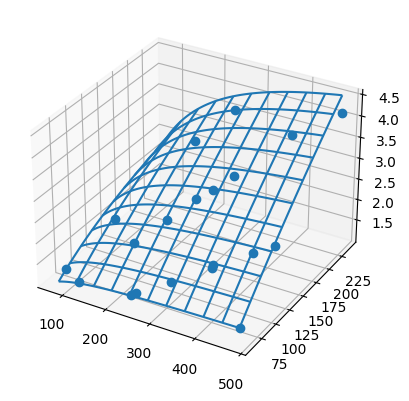

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import measurement
import visu_3d
import visu_common
import linear_model

size = [128]
mem = 'D3'
direction = 'r'
meas_type = 'latency'

clocks = visu_common.get_clocks_in_folder(
        mem, prefix=f'meas_{direction}_',
        clock_lambda=lambda m7, m4: m4 >= 60)
data = np.ndarray((len(clocks), 3, 1))
for i, (m7, m4) in enumerate(clocks):
        dir_prefix = os.path.join(mem, f'meas_{direction}_{m7}_{m4}')
        data[i] = measurement.get_and_calc_meas(m4, dir_prefix, size, meas_type)

model = linear_model.LinearModel('models.json', mem, direction)
m7, m4, pred = model.get_grid_for_range(clocks, size, meas_type)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plot a basic wireframe.
visu_3d.model_grid(m7, m4, pred, ax)
visu_3d.errorbar_3d(clocks, data, ax, mem)

plt.show()

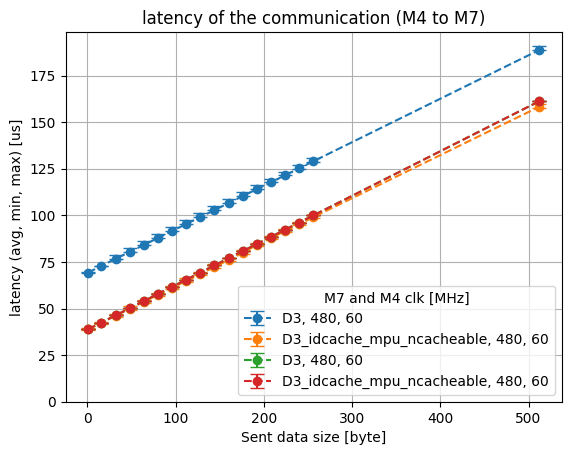

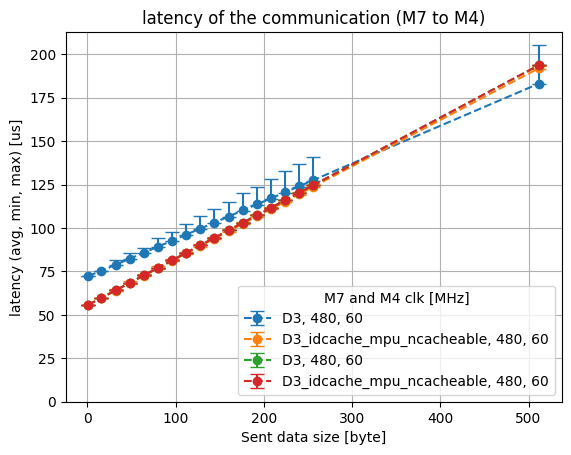

In [15]:
import visu
import visu_common
import numpy as np
import measurement
import matplotlib.pyplot as plt
import linear_model
configs = [{'mem': 'D3', 'clk': (480, 60)},
           {'mem': 'D3_idcache_mpu_ncacheable', 'clk': (480, 60)}]
meas_type = 'latency'

dir = f'{configs[0]["mem"]}/meas_r_{configs[0]["clk"][0]}_{configs[0]["clk"][1]}'
sizes = sorted(visu_common.get_sizes(dir, size_lambda=lambda s: s<530))

for direction in ['r', 's']:
    # Measurement data
    data = np.ndarray((len(configs), 3, len(sizes)))
    for i, config in enumerate(configs):
        mem = config['mem']
        m7, m4 = config['clk']
        dir = f'{config["mem"]}/meas_{direction}_{m7}_{m4}'

        data[i] = measurement.get_and_calc_meas(m4, dir, sizes, meas_type)
    data = measurement.upper_lower_from_minmax(data)
    plt.figure()
    visu.errorbars(configs, sizes, data, meas_type)
    
    # Model predictions
    model = linear_model.LinearModel('models.json', mem, direction)
    pred = np.zeros((len(configs), 3, len(sizes)))
    pred[:, 0] = model.get_output(m7, m4, sizes, meas_type)
    pred_configs = [{'mem': config['mem'] + '_pred',
                     'clk': config['clk']} \
                    for config in configs]
    visu.errorbars(configs, sizes, pred, meas_type)
    visu.setup_errorbars(meas_type, direction)

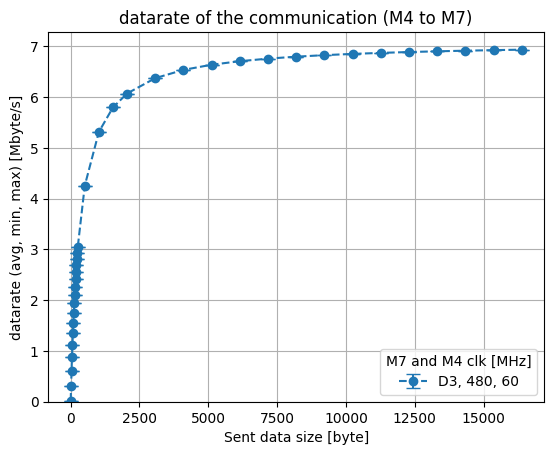

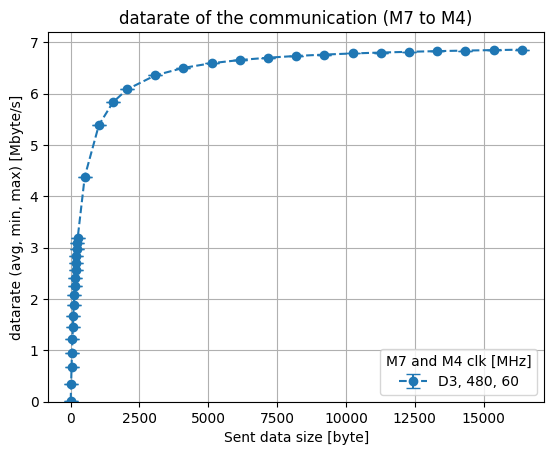

In [10]:
import visu
configs = [{'mem': 'D3', 'clk': (480, 60)}]
meas_type = 'datarate'

dir = f'{configs[0]["mem"]}/meas_r_{configs[0]["clk"][0]}_{configs[0]["clk"][1]}'
sizes = sorted(visu_common.get_sizes(dir))

for direction in ['r', 's']:
    plt.figure()
    
    # Model predictions
    model = linear_model.LinearModel('models.json', mem, direction)
    pred = np.zeros((len(configs), 3, len(sizes)))
    pred[:, 0] = model.get_output(m7, m4, sizes, meas_type)
    pred_configs = [{'mem': config['mem'] + '_pred',
                     'clk': config['clk']} \
                    for config in configs]
    visu.errorbars(configs, sizes, pred, meas_type)
    visu.setup_errorbars(meas_type, direction)

    # todo to show effect of clk, multiple transitional clks